In [1]:
using Random, LaTeXStrings , ColorSchemes , Statistics, Plots, Distributions, LinearAlgebra, CSV, DataFrames

In [2]:
mutable struct MDBox
    n ::Int
    ρ ::Float64
    L :: Float64
    Vmax :: Float64
    xlist :: Vector{Float64}
    ylist :: Vector{Float64}
    vxlist :: Vector{Float64}
    vylist :: Vector{Float64}
    axlist :: Vector{Float64}
    aylist :: Vector{Float64}
    V :: Float64
    K :: Float64
    E :: Float64
    T :: Float64
    P :: Float64
    TRange :: Int
    step :: Float64
end

function Init(n,ρ, L ,Vmax)
    xlist =  zeros(n)
    ylist = zeros(n)                                # Initializing rs
    for i in 1:(2*Int(√(n)))                          # Align Left     
        for j in 1:(Int(√(n)÷2))
        xlist[(j)+(i-1)*Int(√(n)/2)] = j*L/(2*(sqrt(n)/2+1))
        ylist[(j)+(i-1)*Int(√(n)/2)] = i*L/(2*sqrt(n)+1)
        end
    end
    vxlist = rand(Uniform(-Vmax,+Vmax),n) # Initializing Vs
    vxlist = vxlist .- mean(vxlist)                # Checking no net velocity should exist
    vylist = rand(Uniform(-Vmax,+Vmax),n)
    vylist = vylist .- mean(vylist)
    axlist = zeros(n)
    aylist = zeros(n)
    V = 0.0 
    K = 0.0
    E = 0.0
    T=0.0
    P=0.0
    TRange = 1
    step = 0.01
   return MDBox(n,ρ ,L , Vmax  , xlist , ylist , vxlist , vylist , axlist , aylist , V , K , E ,T , P,TRange, step )
end


Init (generic function with 1 method)

Lonard Jones Potential

In [4]:

function Forces(box)
    F = 0.0
    ϵ = 0.001
    box.V = 0.0
    box.axlist = zeros(box.n)
    box.aylist = zeros(box.n)
    
    for i in 1:box.n 
        xrepeati = abs(box.L-abs(box.xlist[i]))
        yrepeati = abs(box.L-abs(box.ylist[i]))
        if ((box.xlist[i]<0) || (box.xlist[i]>box.L))           #Periodic boundary condition 
            box.xlist[i] = xrepeati
        end
        if ((box.ylist[i]<0) || (box.ylist[i]>box.L))
            box.ylist[i] = yrepeati
        end
        for j in 1:i
            rreal = 0.0
            if (i==j)
                continue    
            end
            if box.xlist[i]<(box.L/4) && box.ylist[i] < (box.L/4)               # Boundary conditions for finding the nrighbours in 2.5σ. We only check the two nearest side of the box for each particle based of it's position in the box.
                xrepeatj = box.xlist[j] -  box.L
                yrepeatj = box.ylist[j] -  box.L
            elseif box.xlist[i]<(box.L/4) && box.ylist[i] > (box.L/4)
                xrepeatj = box.xlist[j] -  box.L
                yrepeatj = box.ylist[j] +  box.L
            elseif box.xlist[i]>(box.L/4) && box.ylist[i] < (box.L/4)
                xrepeatj = box.xlist[j] +  box.L
                yrepeatj = box.ylist[j] -  box.L
            else
                xrepeatj = box.xlist[j] +  box.L
                yrepeatj = box.ylist[j] +  box.L
            end  

            deltax = box.xlist[j]-box.xlist[i]                  # Calculating different distances for each two neighbours (including the mirrors)
            deltay = box.ylist[j]-box.ylist[i]
            deltaxrepeat = xrepeatj - box.xlist[i] 
            deltayrepeat = yrepeatj - box.ylist[i] 
            r = sqrt((deltax)^2 +(deltay)^2)
            rhorizontal = sqrt((deltaxrepeat)^2 +(deltay)^2)
            rvertical = sqrt((deltax)^2 +(deltayrepeat)^2)
            rdiagonal = sqrt((deltaxrepeat)^2 +(deltayrepeat)^2)

            if r<2.5                                            # If the j particle is not a neighbour for the i particle, the mirror might be. so the distance is set to be the relating one.
                                                                # A relatively small ϵ was first used for not letting the force to diverge. at last it was set to zero.
                rreal = r+ϵ
            elseif rhorizontal<2.5
                rreal = rhorizontal+ϵ
                deltax = deltaxrepeat
            elseif rvertical<2.5
                rreal = rvertical+ϵ
                deltay = deltayrepeat
            elseif rdiagonal<2.5
                rreal = rdiagonal+ϵ
                deltax = deltaxrepeat
                deltay = deltayrepeat
            else
    
                    continue
            end
            r2 = rreal*rreal
            r6 = r2*r2*r2
            r12 = r6*r6
            v = 4*((1/r12)-(1/r6))                    # Calculating Lennard Jones potential
            box.V += v
            F = -(4/(r2))*((12/(r12))-(6/(r6)))
            ax = F *deltax                                   # The force decomposed to x and y direction
            ay = F *deltay
            box.axlist[i] += ax
            box.axlist[j] += -ax
            box.aylist[i] += ay
            box.aylist[j] += -ay


        end
    end

end


Forces (generic function with 1 method)

Velocity Verlet method for solving diffrential equation

In [5]:
function velverlet(box)
    for t in 1:box.TRange
        box.vxlist = box.vxlist + 1/2 * box.step * box.axlist
        box.vylist = box.vylist + 1/2 * box.step * box.aylist
        box.xlist = box.xlist + box.step * box.vxlist
        box.ylist = box.ylist + box.step * box.vylist
        Forces(box)                                             # Updating accelaraions
        box.vxlist = box.vxlist + 1/2 * box.step * box.axlist
        box.vylist = box.vylist + 1/2 * box.step * box.aylist   
   
        box.vxlist = box.vxlist .- mean(box.vxlist)                # Checking that no net velocity should exist due to errors.
        box.vylist = box.vylist .- mean(box.vylist)
        box.K = sum(box.vxlist.^2 + box.vylist.^2) /2
        box.E = box.K + box.V 
        box.T = box.K/box.n         
        box.P = box.n * box.T / (box.L*box.L) + (dot(box.xlist,box.axlist) + dot(box.ylist ,box.aylist))/(3*(box.L*box.L))      #using virial
    end
    

end


velverlet (generic function with 1 method)

Simulating and Plotting

In [19]:
mdinit = Init(100,1,30,2)

MDBox(100, 1.0, 30.0, 2.0, [2.5, 5.0, 7.5, 10.0, 12.5, 2.5, 5.0, 7.5, 10.0, 12.5  …  2.5, 5.0, 7.5, 10.0, 12.5, 2.5, 5.0, 7.5, 10.0, 12.5], [1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 1.4285714285714286, 2.857142857142857, 2.857142857142857, 2.857142857142857, 2.857142857142857, 2.857142857142857  …  27.142857142857142, 27.142857142857142, 27.142857142857142, 27.142857142857142, 27.142857142857142, 28.571428571428573, 28.571428571428573, 28.571428571428573, 28.571428571428573, 28.571428571428573], [-1.349784820243587, 1.2702455732608877, 0.09349438709697055, 0.9624913138695311, -1.7114260458784818, 1.4595648509995218, 0.20631345231739384, -0.1307767178155098, -0.10073291210647561, -0.7290127140713617  …  1.3863240060120656, -1.54475857539438, -0.5279743648943916, -0.6114167596547718, -1.259172995139803, 1.0323934423651244, -0.4072344179378128, -0.5405956957330013, 0.5544706094122577, 0.34321253342407887], [-0.6769232993752636, 0.12976090426871736, 0

In [17]:
 for i in 1:1000
    velverlet(mdinit)
 end

In [217]:
mdinit.axlist

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

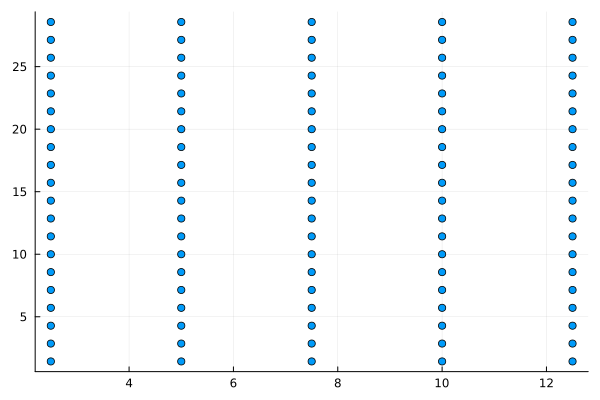

In [20]:
scatter(mdinit.xlist,mdinit.ylist, label = false)
# plot!(xlim = [0,30], ylim = [0,30])


Getting Data

In [21]:
simrun = 10000
Xs = zeros(mdinit.n, simrun)
Ys = zeros(mdinit.n, simrun)
vels = zeros(mdinit.n, simrun)
Ks = zeros(simrun)
Es = zeros(simrun)
Ts = zeros( simrun)
Vs = zeros(simrun)
Ps = zeros(simrun)

for t in 1:simrun
    velverlet(mdinit)                                           #extracting needed quantities.
    Xs[:,t] = mdinit.xlist
    Ys[:,t] = mdinit.ylist
    vels[:,t] = (mdinit.vxlist.^2 + mdinit.vylist.^2)
    Ks[t]  = mdinit.K
    Es[t] = mdinit.E
    Vs[t] = mdinit.V
    Ts[t] = mdinit.T
    Ps[t] = mdinit.P
end

Trajectory: Animation

In [ ]:

MdAnime = @animate for L in 1:simrun
    scatter(Xs[:,L],Ys[:,L], xlim = [0,30], ylim = [0,30])
end


In [ ]:
gif(MdAnime, fps = 30)

N(t)

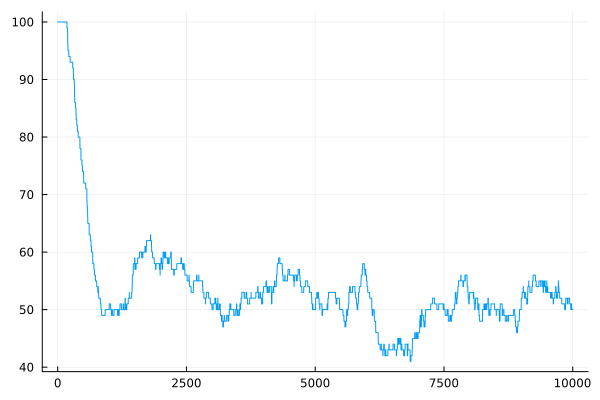

In [22]:
count = zeros(simrun)
for L in 1:simrun
for i in 1:mdinit.n
    if Xs[i,L] < (mdinit.L/2)
        count[L] +=1
    end
end
end
plot(count, label = false)

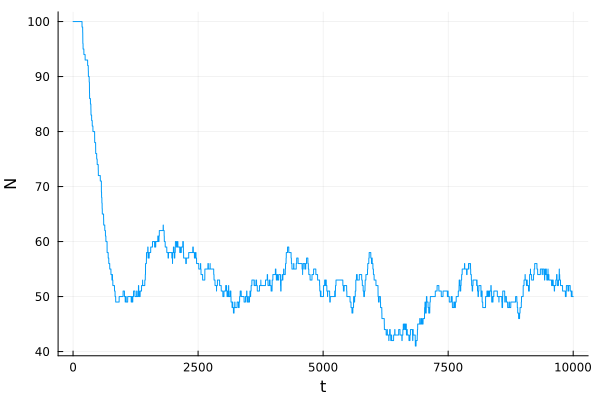

In [23]:
plot!(xaxis = "t", yaxis = "N")

Energy Conservation

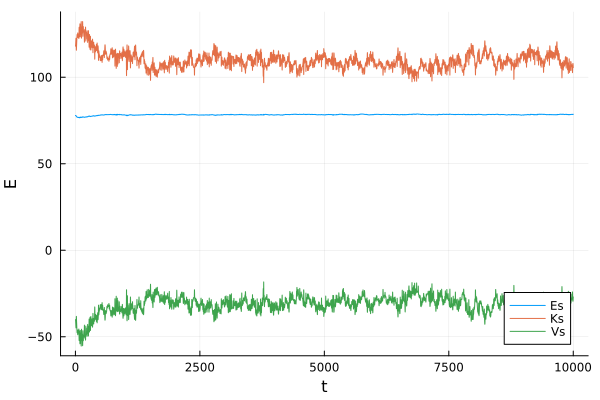

In [26]:
 plot(Es, label = "Es", lable = "E")
plot!(Ks, label = "Ks", lable = "K")
plot!(Vs , label = "Vs", lable = "U")
plot!(xaxis = "t", yaxis = "E")

AutoCorrelations

In [28]:
function AutoCorrelation(array,n)
    AutoCorr = zeros(n)
    @simd for j in  1:n
        AutoCorr[j] = (sum((array[1:(n-j)] .- mean(array)) .* (array[(j+1):(n)] .- mean(array))))/ (n*var(array))         # Using Auto-Correlation Formula
    end
    return AutoCorr
end

AutoCorrelationArray = AutoCorrelation(Vs,simrun)

10000-element Vector{Float64}:
  0.9887825458088381
  0.9597964061417986
  0.9220168784537008
  0.8844613256759158
  0.8528831496798037
  0.8294598031086031
  0.8139239264827623
  0.8048244763075544
  0.8004082627220905
  0.7991254114389197
  ⋮
 -0.0010794005424559902
 -0.0009569505016768749
 -0.0008421147743536862
 -0.000728407449854408
 -0.0006092055934787741
 -0.00047945573288795464
 -0.00033343704028881716
 -0.00017244667653565417
  0.0

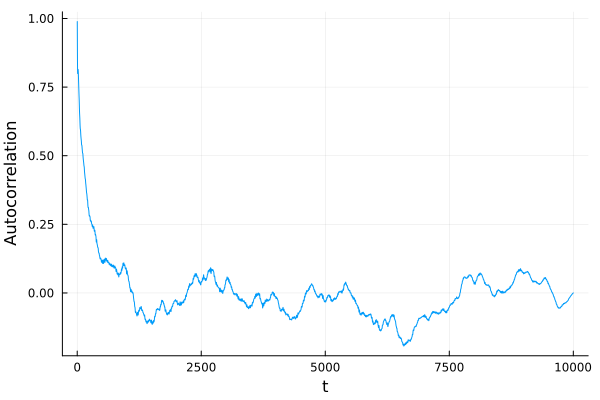

In [32]:
plot(AutoCorrelationArray, lable = false)
plot!(xaxis = "t", yaxis = "Autocorrelation", legend = false)

Temparature and Pressure

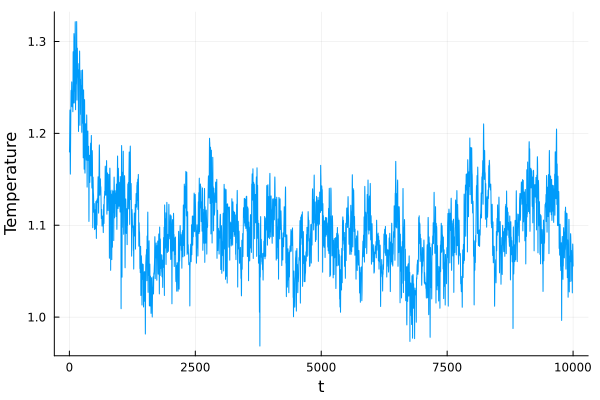

In [36]:
movingaverage(array,n) = [sum(@view array[i:(i+n-1)])/n for i in 1:(length(array)-(n-1))]
# Tsmooth = movingaverage(Ts,5000)
# Psmooth = movingaverage(Ps,5000)
plot(Ts,legend = false)
plot!(xaxis = "t", yaxis = "Temperature")
# plot!(Tsmooth)

In [38]:
length(Psmooth)

5001

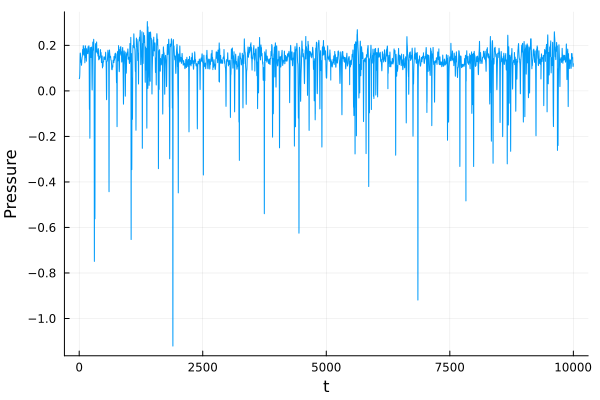

In [37]:
plot(Ps, legend =false)
# plot!(Psmooth)
plot!(xaxis = "t", yaxis = "Pressure")


Van  der Waals

In [9]:
simrun = 500000
Paverage =zeros(100)
Taverage = zeros(100)
Tlist = zeros(simrun)
Plist = zeros(simrun)

for i in 1:100
    mddata =  Init(100,1,30,1+(i/50))
    for t in 1:simrun
        velverlet(mddata)
        Tlist[t] = mddata.T
        Plist[t] = mddata.P
    end
    Taverage[i] = movingaverage(Tlist,Int(0.7*simrun ))[end]
    Paverage[i] = movingaverage(Plist,Int(0.7*simrun ))[end]
end


In [13]:
print(Taverage)

[0.5268143893543249, 0.5341745164412238, 0.5537833862931165, 0.5236507476104556, 0.5601752658392148, 0.5699515897397103, 0.5635675987089569, 0.5676200469645954, 0.5800618556670532, 0.590352213789719, 0.5769214778257528, 0.5957004887513585, 0.6179798150491218, 0.6311570597278758, 0.6092190878345983, 0.6334489165419854, 0.6472340459755166, 0.6464331824628367, 0.6464001631979517, 0.6831587932959758, 0.6872629135108617, 0.7202476209529456, 0.7859540299693176, 0.7331774045595675, 0.7626245404089262, 0.783775015836045, 0.7776207674426323, 0.8666020039368085, 0.8458949364104725, 0.8075856382776097, 0.8086767296225774, 0.8789829161591916, 1.030601350416514, 0.8617533630299485, 0.8474571504057296, 0.9234634397049125, 0.9352877404927435, 0.9143753687647249, 0.9157823916913956, 0.9690288463660157, 1.0784067225233303, 1.0597890977375628, 1.106501992323421, 1.0572039123636439, 1.079375236975548, 1.142129465020798, 1.1910296731018548, 1.1358516015630973, 1.2493842747322652, 

1.254586214166999, 1.2142958545693292, 1.3702574526163542, 1.3258530420685763, 1.3442225135596866, 1.296379060328885, 1.4480843714379892, 1.3795025116824304, 1.3963878424832905, 1.516804750143243, 1.6055496833581997, 1.4030081389933358, 1.5104782826076841, 1.6833760994174172, 1.5423658019419986, 1.6709051810968873, 1.4533480422979579, 1.780925382617662, 1.4789943752436772, 1.5244140222924738, 1.8682130109068738, 1.8851714195968963, 1.9516563799825104, 1.6885675125740265, 1.8330215035332735, 1.9599641236716465, 1.9608665893901074, 1.9095086638632344, 2.0949232886060316, 2.088383646623291, 1.9574310612460573, 2.2596433359307655, 2.187565970547254, 2.4192537430376473, 2.076947108887121, 2.310757750232276, 2.132926856165011, 2.0500025099696204, 2.218422871038816, 2.475670028976649, 1.9775285762219903, 2.4690054717035, 2.5797041386185193, 2.7269227286206905, 2.4065531102306106, 2.273885861755891, 2.2907609057766796, 2.684323700429697, 2.5912989847611563, 2.6747136610180364, 2.89107068572913

In [26]:
tTable = Tables.table(Taverage)
CSV.write("tdata.csv",tTable)

"tdata.csv"

In [ ]:
df = CSV.reads

In [27]:
pTable = Tables.table(Paverage)
CSV.write("pdata.csv",pTable)

"pdata.csv"

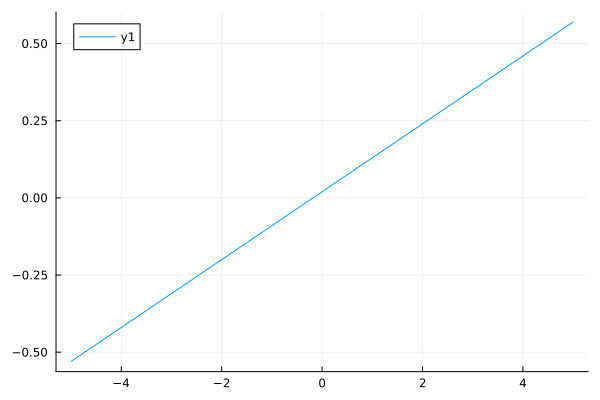

In [45]:
# plot(Taverage,Paverage, label = false)
# plot!(xaxis = "T" , yaxis = "P")
plot(x->0.02 + 0.11*x)

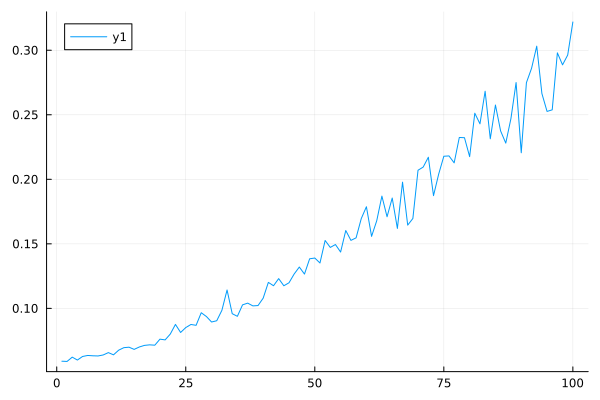

In [14]:
plot(Paverage)


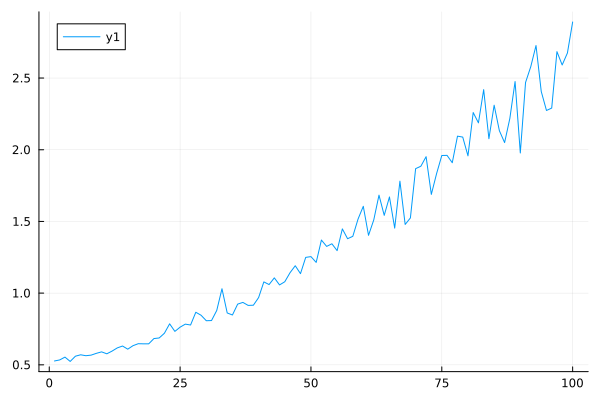

In [15]:
plot(Taverage)

In [16]:
A= [ones(100) Taverage]
para = A \ Paverage

2-element Vector{Float64}:
 0.0002336291397499763
 0.11101799498332597

Phase Transition

In [42]:
mdscale = Init(100,1,30,5)
Ts = zeros( simrun)
Ps = zeros(simrun)

for t in 1:simrun
    velverlet(mdscale)
    if t%100 == 1
        mdscale.vxlist = 0.4 * mdscale.vxlist
        mdscale.vylist = 0.4 * mdscale.vylist

    end
    Ts[t] = mdscale.T
    Ps[t] = mdscale.P
end

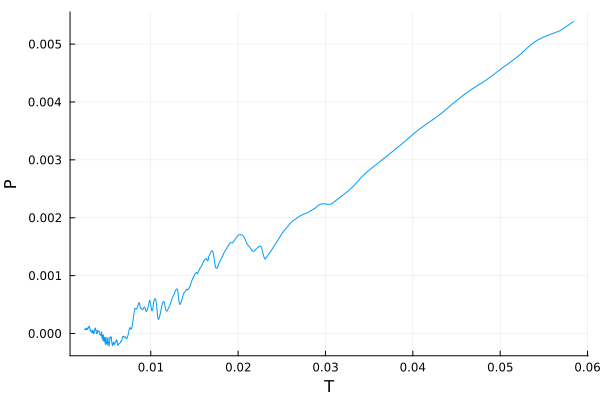

In [43]:
Tsmooth = movingaverage(Ts,5000)
Psmooth = movingaverage(Ps,5000)
plot(Tsmooth,Psmooth, legend= false)
plot!(xaxis = "T", yaxis = "P")